In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import math
import datetime
import pprint
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
#%load_ext tensorboard

(train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)

2022-12-08 10:01:52.904686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 10:01:53.191118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 10:01:53.191141: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 10:01:54.066900: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
def preprocessing(data):
    # convert values into float
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # bringing image values to range [-1,1]
    data = data.map(lambda img, target: ((img/128.)-1., target))
    # create one-hot targets
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # cache progress in memory
    data = data.cache()
    # shuffle, batch, prefetch
    data = data.shuffle(1000)
    data = data.batch(32)
    data = data.prefetch(20)
    # return processed dataset
    return data

In [13]:
def preprocessing_augmented(data):
    # convert values into float
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # bringing image values to range [-1,1]
    data = data.map(lambda img, target: ((img/128.)-1., target))
    # create one-hot targets
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # cache progress in memory
    data = data.cache()
    # shuffle, batch, prefetch
    data = data.shuffle(1000)
    data = data.batch(32)
    data = data.prefetch(20)
    # augment data
    augmentation_model = tf.keras.Sequential([keras_cv.layers.RandAugment(value_range=[-1,1],magnitude=0.1)])
    data = data.map(lambda x,y : (augmentation_model(x), y),num_parallel_calls=tf.data.AUTOTUNE)
    # return processed dataset
    return data

In [4]:
# apply preprocessing to the data
#train_data = train_ds.apply(preprocessing)
#test_data = test_ds.apply(preprocessing)

In [5]:
# a basic CNN, copied from the lecture
class BasicCNN(tf.keras.Model):
    def __init__(self, optimizer):
        super(BasicCNN, self).__init__()
        
        # optimizer
        self.optimizer = optimizer
        
        # loss function
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        
        # some metrics
        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss"),
            tf.keras.metrics.CategoricalAccuracy(name="acc")
        ]
        
        # layer architecture
        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)
        
        self.convlayer5 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu')
        self.convlayer6 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')
    
    # get activation
    def call(self, x, training=False):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling1(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.pooling2(x)
        x = self.convlayer5(x)
        x = self.convlayer6(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x
    
    # get metrics
    @property
    def metrics(self):
        return self.metrics_list
    
    # reset all metrics
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
            
    # define train step
    @tf.function
    def train_step(self,data):
        
        x, targets = data
        
        # get gradients an apply them to the optimizer
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            loss = self.loss_function(targets,predictions)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update metrics
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(targets,predictions)
        
        # return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    # test step
    @tf.function
    def test_step(self, data):
        
        x, targets = data
        predictions = self(x, training=False)
        loss = self.loss_function(targets,predictions)
        
        # update metrics
        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(targets,predictions)
        
        return {m.name: m.result() for m in self.metrics}

In [6]:
# the basic architecture but with different possibilities for regularization
# 1. kernel_regularization via the L2 norm
# 2. dropout units
# 3. batch normalization
class ConvModel(tf.keras.Model):
    def __init__(self, optimizer, L2_reg=0, dropout_rate=0, batch_norm=False):
        super().__init__()
        
        kernel_regularizer=tf.keras.regularizers.L2(L2_reg) if L2_reg else None
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        
        if self.dropout_rate:
            self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
            
        self.layer_list = [
            tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        
            tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.GlobalAvgPool2D(),

            tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=kernel_regularizer)]
        
        if batch_norm:
            
                self.layer_list = [
                    tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

                    tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        
                    tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.GlobalAvgPool2D(),

                    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=kernel_regularizer)]
                
                
        # metrics to update
        self.frobenius_metric = tf.keras.metrics.Mean(name="total_frobenius_norm")
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name="acc")
        
    def call(self, x, training=False):
        for layer in self.layer_list[:-1]:
            x = layer(x)
            if self.dropout_rate:
                x = self.dropout_layer(x, training)
        
        return self.layer_list[-1](x)
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
            
    def compute_frobenius(self):
        frobenius_norm = tf.zeros((1,))
        for var in self.trainable_variables:
            frobenius_norm += tf.norm(var, ord="euclidean")
        return frobenius_norm
    
    @tf.function
    def train_step(self, data):
        x, target = data
        with tf.GradientTape() as tape:
            prediction = self(x, training=True)
            # we have to include the loss values that are written by the regularizer
            # @TODO: I am not sure if it is written correctly this way
            loss = self.loss_function(target, prediction) + sum(self.losses)
            #loss = self.loss_function(target,prediction) + tf.losses.get_regularization_loss()
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.frobenius_metric.update_state(self.compute_frobenius())
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(target, prediction)
        
        return {metric.name: metric.result() for metric in self.metrics}
    
    @tf.function
    def test_step(self, data):
        x, target = data
        prediction = self(x, training=False)
        loss = self.loss_function(target, prediction)
        
        self.frobenius_metric.update_state(self.compute_frobenius())
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(target, prediction)
        
        return {metric.name: metric.result() for metric in self.metrics}

In [21]:
# the basic architecture but with different possibilities for regularization
# 1. kernel_regularization via the L2 norm
# 2. dropout units
# 3. batch normalization
class DeepConvModel(tf.keras.Model):
    def __init__(self, optimizer, L2_reg=0, dropout_rate=0, batch_norm=False):
        super().__init__()
        
        kernel_regularizer=tf.keras.regularizers.L2(L2_reg) if L2_reg else None
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        
        if self.dropout_rate:
            self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
            
        self.layer_list = [
            tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        
            tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
            
            tf.keras.layers.Conv2D(filters=192, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Conv2D(filters=192, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
            tf.keras.layers.GlobalAvgPool2D(),

            tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=kernel_regularizer)]
        
        if batch_norm:
            
                self.layer_list = [
                    tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

                    tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        
                    tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
            
                    tf.keras.layers.Conv2D(filters=192, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2D(filters=192, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.GlobalAvgPool2D(),

                    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=kernel_regularizer)]
                
                
        # metrics to update
        self.frobenius_metric = tf.keras.metrics.Mean(name="total_frobenius_norm")
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name="acc")
        
    def call(self, x, training=False):
        for layer in self.layer_list[:-1]:
            x = layer(x)
            if self.dropout_rate:
                x = self.dropout_layer(x, training)
        
        return self.layer_list[-1](x)
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
            
    def compute_frobenius(self):
        frobenius_norm = tf.zeros((1,))
        for var in self.trainable_variables:
            frobenius_norm += tf.norm(var, ord="euclidean")
        return frobenius_norm
    
    @tf.function
    def train_step(self, data):
        x, target = data
        with tf.GradientTape() as tape:
            prediction = self(x, training=True)
            # we have to include the loss values that are written by the regularizer
            # @TODO: I am not sure if it is written correctly this way
            loss = self.loss_function(target, prediction) + sum(self.losses)
            #loss = self.loss_function(target,prediction) + tf.losses.get_regularization_loss()
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.frobenius_metric.update_state(self.compute_frobenius())
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(target, prediction)
        
        return {metric.name: metric.result() for metric in self.metrics}
    
    @tf.function
    def test_step(self, data):
        x, target = data
        prediction = self(x, training=False)
        loss = self.loss_function(target, prediction)
        
        self.frobenius_metric.update_state(self.compute_frobenius())
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(target, prediction)
        
        return {metric.name: metric.result() for metric in self.metrics}

In [7]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer):
    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        
        # Training:
        
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)
            
            # logging the validation metrics to the log file which is used by tensorboard
            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics (requires a reset_metrics method in the model)
        model.reset_metrics()    
        
        # Validation:
        for data in val_ds:
            metrics = model.test_step(data)
        
            # logging the validation metrics to the log file which is used by tensorboard
            with val_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
                    
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics
        model.reset_metrics()
        print("\n")

In [8]:
#used for visualize the data with plt instead of tensorboard
def training_loop_visual(model, train_ds, val_ds, epochs):
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        
        # Training:
        
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)
            
        for (key, value) in metrics.items():
            if key == 'acc':
                train_accuracies.append(value.numpy())
            if key == 'loss':
                train_losses.append(value.numpy())

        # print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics (requires a reset_metrics method in the model)
        model.reset_metrics()    
        
        # Validation:
        for data in val_ds:
            metrics = model.test_step(data)
        
        for (key, value) in metrics.items():
            if key == 'acc':
                test_accuracies.append(value.numpy())
            if key == 'loss':
                test_losses.append(value.numpy())
                    
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics
        model.reset_metrics()
        print("\n")
        
    return train_losses, train_accuracies, test_losses, test_accuracies

In [9]:
def automated_training(optimizer, epochs,label):
    
    # create the model
    #model = BasicCNN(optimizer)
    model = ConvModel(optimizer, L2_reg=0.2, batch_norm=True)
    
    # Define where to save the log
    config_name= "config_name"
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train/{label}"
    val_log_path = f"logs/{config_name}/{current_time}/val/{label}"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    # run the training loop 
    training_loop(model=model, 
            train_ds=train_data, 
            val_ds=test_data, 
            epochs=epochs, 
            train_summary_writer=train_summary_writer, 
            val_summary_writer=val_summary_writer)

In [22]:
def automated_training_visual(optimizer,epochs,label, L2_reg=0, dropout_rate=0, batch_norm=False, augmentation=False):
    
    # generate data
    if augmentation:
        train_data = train_ds.apply(preprocessing_augmented)
    else:
        train_data = train_ds.apply(preprocessing)
    test_data = test_ds.apply(preprocessing)
    
    # create the model
    #model = ConvModel(optimizer, L2_reg = L2_reg, dropout_rate = dropout_rate, batch_norm = batch_norm)
    model = DeepConvModel(optimizer, L2_reg = L2_reg, dropout_rate = dropout_rate, batch_norm = batch_norm)
    
    # run the training loop 
    train_loss, train_acc, test_loss, test_acc = training_loop_visual(model=model, 
            train_ds=train_data, 
            val_ds=test_data, 
            epochs=epochs)
    
    visualization(train_loss, train_acc, test_loss, test_acc, label)

In [11]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies, label):
    #print(test_accuracies)
    plt.figure()
    line1, = plt.plot(train_losses , "b-")
    line2, = plt.plot(test_losses , "r-")
    line3, = plt.plot(train_accuracies , "b:")
    line4, = plt.plot(test_accuracies , "r:")
    
    plt.title(label)
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1 , line2 , line3 , line4), 
             ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

Epoch 0:


100%|███████████████████████████████████████| 1563/1563 [00:41<00:00, 37.36it/s]


['total_frobenius_norm: 135.48204040527344', 'loss: 1.8525265455245972', 'acc: 0.5171200037002563']
['val_total_frobenius_norm: 133.5036163330078', 'val_loss: 1.0404062271118164', 'val_acc: 0.6455000042915344']


Epoch 1:


100%|███████████████████████████████████████| 1563/1563 [00:38<00:00, 40.67it/s]


['total_frobenius_norm: 135.76113891601562', 'loss: 1.4155629873275757', 'acc: 0.6414999961853027']
['val_total_frobenius_norm: 138.32302856445312', 'val_loss: 0.8360080122947693', 'val_acc: 0.713699996471405']


Epoch 2:


100%|███████████████████████████████████████| 1563/1563 [00:38<00:00, 40.32it/s]


['total_frobenius_norm: 140.67266845703125', 'loss: 1.3346784114837646', 'acc: 0.6792600154876709']
['val_total_frobenius_norm: 142.41932678222656', 'val_loss: 0.7638340592384338', 'val_acc: 0.7301999926567078']


Epoch 3:


100%|███████████████████████████████████████| 1563/1563 [00:38<00:00, 40.34it/s]


['total_frobenius_norm: 143.878173828125', 'loss: 1.299346685409546', 'acc: 0.6957799792289734']
['val_total_frobenius_norm: 144.91546630859375', 'val_loss: 0.7314386963844299', 'val_acc: 0.7487999796867371']


Epoch 4:


100%|███████████████████████████████████████| 1563/1563 [00:39<00:00, 40.05it/s]


['total_frobenius_norm: 146.03428649902344', 'loss: 1.2589976787567139', 'acc: 0.7091799974441528']
['val_total_frobenius_norm: 146.8356170654297', 'val_loss: 0.6744075417518616', 'val_acc: 0.7638999819755554']


Epoch 5:


100%|███████████████████████████████████████| 1563/1563 [00:39<00:00, 39.85it/s]


['total_frobenius_norm: 147.39048767089844', 'loss: 1.234621524810791', 'acc: 0.718280017375946']
['val_total_frobenius_norm: 148.11044311523438', 'val_loss: 0.6845613121986389', 'val_acc: 0.7685999870300293']


Epoch 6:


100%|███████████████████████████████████████| 1563/1563 [00:38<00:00, 40.29it/s]


['total_frobenius_norm: 148.85760498046875', 'loss: 1.2021472454071045', 'acc: 0.7283200025558472']
['val_total_frobenius_norm: 149.24330139160156', 'val_loss: 0.6966299414634705', 'val_acc: 0.7634999752044678']


Epoch 7:


100%|███████████████████████████████████████| 1563/1563 [00:38<00:00, 40.31it/s]


['total_frobenius_norm: 149.668212890625', 'loss: 1.1829215288162231', 'acc: 0.7325199842453003']
['val_total_frobenius_norm: 150.14842224121094', 'val_loss: 0.7507221102714539', 'val_acc: 0.7487000226974487']


Epoch 8:


100%|███████████████████████████████████████| 1563/1563 [00:38<00:00, 40.83it/s]


['total_frobenius_norm: 150.666015625', 'loss: 1.1587133407592773', 'acc: 0.7405200004577637']
['val_total_frobenius_norm: 151.0244598388672', 'val_loss: 0.6448692679405212', 'val_acc: 0.7838000059127808']


Epoch 9:


100%|███████████████████████████████████████| 1563/1563 [00:38<00:00, 40.67it/s]


['total_frobenius_norm: 151.49522399902344', 'loss: 1.145355463027954', 'acc: 0.7426000237464905']
['val_total_frobenius_norm: 151.83204650878906', 'val_loss: 0.6574735641479492', 'val_acc: 0.7736999988555908']


Epoch 10:


100%|███████████████████████████████████████| 1563/1563 [00:39<00:00, 39.44it/s]


['total_frobenius_norm: 151.9821319580078', 'loss: 1.1329172849655151', 'acc: 0.745419979095459']
['val_total_frobenius_norm: 152.17054748535156', 'val_loss: 0.6449496150016785', 'val_acc: 0.781000018119812']


Epoch 11:


100%|███████████████████████████████████████| 1563/1563 [00:39<00:00, 39.48it/s]


['total_frobenius_norm: 152.78433227539062', 'loss: 1.1133674383163452', 'acc: 0.7519999742507935']
['val_total_frobenius_norm: 153.10543823242188', 'val_loss: 0.6121092438697815', 'val_acc: 0.786300003528595']


Epoch 12:


100%|███████████████████████████████████████| 1563/1563 [00:39<00:00, 39.55it/s]


['total_frobenius_norm: 153.4982452392578', 'loss: 1.1087578535079956', 'acc: 0.751259982585907']
['val_total_frobenius_norm: 153.67552185058594', 'val_loss: 0.6262732744216919', 'val_acc: 0.7889000177383423']


Epoch 13:


100%|███████████████████████████████████████| 1563/1563 [00:38<00:00, 40.35it/s]


['total_frobenius_norm: 154.00738525390625', 'loss: 1.0956954956054688', 'acc: 0.7542799711227417']
['val_total_frobenius_norm: 154.48934936523438', 'val_loss: 0.5817185640335083', 'val_acc: 0.801800012588501']


Epoch 14:


100%|███████████████████████████████████████| 1563/1563 [00:38<00:00, 40.61it/s]


['total_frobenius_norm: 154.7223358154297', 'loss: 1.0864906311035156', 'acc: 0.7582799792289734']
['val_total_frobenius_norm: 155.09890747070312', 'val_loss: 0.6005433797836304', 'val_acc: 0.7950000166893005']




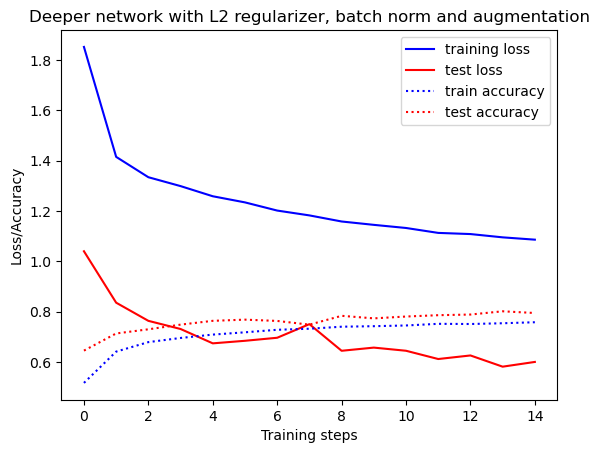

In [24]:
automated_training_visual(tf.keras.optimizers.Adam(),15,"Deeper network with L2 regularizer, batch norm and augmentation",
                          L2_reg = 0.001, dropout_rate = 0, batch_norm = True, augmentation=True)

In [ ]:
%tensorboard --logdir logs/